In [37]:
# Let's create a simple torch model

import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(41)

# Define the model
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Define the forward pass in the network
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [38]:
# Import the test data
import matplotlib.pyplot as plt
import pandas as pd

name_of_stock = input("Enter the name of the stock: ")

df = pd.read_csv(f"stocks/{name_of_stock}.csv")

df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,0.837449,0.837449,0.823045,0.823045,0.145748,352200
1,1962-01-03,0.835391,0.851852,0.835391,0.839506,0.148663,710400
2,1962-01-04,0.839506,0.853909,0.831276,0.831276,0.147205,911000
3,1962-01-05,0.831276,0.835391,0.792181,0.814815,0.144290,880400
4,1962-01-08,0.814815,0.829218,0.804527,0.816872,0.144654,473600
...,...,...,...,...,...,...,...
14658,2020-03-26,172.289993,186.479996,167.179993,180.550003,180.550003,63267300
14659,2020-03-27,172.000000,172.919998,155.539993,162.000000,162.000000,47880200
14660,2020-03-30,153.809998,153.809998,140.679993,152.279999,152.279999,51052500
14661,2020-03-31,155.000000,160.639999,149.000000,149.139999,149.139999,29954000


In [39]:
# remove the date column and Adj Close
df = df.drop(columns=['Date'])
df = df.drop(columns=['Adj Close'])
# Drop volume
df = df.drop(columns=['Volume'])
# Switch the Close and Volume columns
close = df.pop("Close")
# Insert at the end of the dataframe
df.insert(len(df.columns), "Close", close)
df

,Open,High,Low,Close
0,0.837449,0.837449,0.823045,0.823045
1,0.835391,0.851852,0.835391,0.839506
2,0.839506,0.853909,0.831276,0.831276
3,0.831276,0.835391,0.792181,0.814815
4,0.814815,0.829218,0.804527,0.816872
...,...,...,...,...
14658,172.289993,186.479996,167.179993,180.550003
14659,172.000000,172.919998,155.539993,162.000000
14660,153.809998,153.809998,140.679993,152.279999
14661,155.000000,160.639999,149.000000,149.139999


In [40]:
number_of_features = len(df.columns) - 1
number_of_features

3

In [41]:
# Split the data into training and testing
# I have chosen to now use the SKLearn train_test_split function because 
# I want to keep the data in order

percent_train = 0.8
percent_test = 1 - percent_train

train_data = df.iloc[:int(len(df) * percent_train)]
test_data = df.iloc[int(len(df) * percent_train):]

In [42]:
# check that the data is split correctly based on df shapes

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Original data shape: {df.shape}")

assert train_data.shape[0] + test_data.shape[0] == df.shape[0]
assert train_data.shape[1] == df.shape[1]

Train data shape: (11730, 4)
Test data shape: (2933, 4)
Original data shape: (14663, 4)


In [43]:
# Finally, split the data into X and y
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]

X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

In [44]:
X_train

,Open,High,Low
0,0.837449,0.837449,0.823045
1,0.835391,0.851852,0.835391
2,0.839506,0.853909,0.831276
3,0.831276,0.835391,0.792181
4,0.814815,0.829218,0.804527
...,...,...,...
11725,63.000000,63.000000,61.009998
11726,61.389999,62.279999,60.770000
11727,62.080002,62.330002,61.130001
11728,61.869999,65.680000,61.860001


In [45]:
# I want to create a LSTM model that predicts the next day's closing price
# to do this, I intend to take in the previous 5 days' metrics (open, high, low, close, volume)
# and predict the next day's closing price

import os
import sys
from colorama import Fore
import numpy as np

class DynamicModel:
    def __init__(self, number_of_days, number_of_features=5, batch_size = 10 ):

        # Makes it so that the model's input size is the number of features times the number of days
        self.model = SimpleModel(input_size = number_of_features * number_of_days, output_size=1, hidden_size=50)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.number_of_features = number_of_features
        self.number_of_days = number_of_days
        self.batch_size = batch_size
        self.losses = []
        self.predictions = []

    def info(self):
        print(f"Model: {self.model}")
        print(f"Optimizer: {self.optimizer}")
        print(f"Number of features: {self.number_of_features}")
        print(f"Number of days: {self.number_of_days}")
        print(f"Batch size: {self.batch_size}")

    def get_random_set(self, x_train, y_train):
        # Get a random batch of data
        # This will consider the number of days
        # it should also make sure that whatever index it chooses is not out of bounds

        random_index = np.random.randint(0, len(x_train) - self.number_of_days - 1)

        x_batch = x_train.iloc[random_index:random_index + self.number_of_days]
        # y batch should just be the next day's closing price
        y_batch = y_train.iloc[random_index + self.number_of_days]

        x_batch = torch.tensor(x_batch.values).float().flatten()
        y_batch = torch.tensor(y_batch).float().flatten()

        return x_batch, y_batch


    def train(self, x_train, y_train, epochs):
        # Train the model
        self.losses = []

        for epoch in range(epochs + 1):
            # Get a random batch of data
            x_batch, y_batch = self.get_random_set(x_train, y_train)

            # Forward pass
            y_out = self.model.forward(x_batch)

            # Calculate the loss
            loss = self.criterion(y_out, y_batch)
            self.losses.append(loss.item())

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Print out a comparison of the predicted and actual values every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch: {epoch} Loss: {loss.item()} Predicted: {y_out.item()} Actual: {y_batch.item()}")

        
        print(f"{Fore.GREEN}\nTraining complete{Fore.RESET}")

    def validate(self, x_test, y_test):
        # Validate the model
        # Run the model with the x_test data
        # and compare it to the y_test data

        correct = 0

        for i in range(len(x_test) - self.number_of_days - 1):
            x_batch = x_test.iloc[i:i + self.number_of_days]
            y_batch = y_test.iloc[i + self.number_of_days]

            x_batch = torch.tensor(x_batch.values).float().flatten()
            y_batch = torch.tensor(y_batch).float().flatten()

            y_out = self.model.forward(x_batch).item()

            error = abs(y_out - y_batch)
            if error < 0.5:
                correct += 1

            self.predictions.append((y_out, y_batch))

            self.print_inline(f"Validation: {i + 1}/{len(x_test) - self.number_of_days - 1}")
        
        print(f"\nAccuracy: {correct / (len(x_test) - self.number_of_days - 1)}")
        
    def print_inline(self, string):
        sys.stdout.write("\r" + string)
        sys.stdout.flush()

    def forecast(self, last_n_days, days = 10):
        # Using the model, come up with a forecase for the next n days
        # You will have to recycle your predictions into the model for the next day's prediction

        forecast = last_n_days
        

Broker = DynamicModel(number_of_days = 30, number_of_features = number_of_features, batch_size = 10)
Broker.train(X_train, y_train, 200)
Broker.validate(X_test, y_test)

Epoch: 0 Loss: 8.43637752532959 Predicted: 0.48640209436416626 Actual: 3.390946388244629
Epoch: 10 Loss: 75.79334259033203 Predicted: 14.731562614440918 Actual: 23.4375
Epoch: 20 Loss: 0.1037694439291954 Predicted: 0.9517622590065002 Actual: 0.6296296119689941
Epoch: 30 Loss: 495.63677978515625 Predicted: 62.387901306152344 Actual: 40.125
Epoch: 40 Loss: 0.07085803151130676 Predicted: 1.1056978702545166 Actual: 0.8395061492919922
Epoch: 50 Loss: 3.383389949798584 Predicted: 7.605045318603516 Actual: 9.44444465637207
Epoch: 60 Loss: 84.11202239990234 Predicted: 45.641239166259766 Actual: 54.8125
Epoch: 70 Loss: 0.028433946892619133 Predicted: 0.8023685216903687 Actual: 0.6337448358535767
Epoch: 80 Loss: 226.28195190429688 Predicted: 95.2626724243164 Actual: 80.22000122070312
Epoch: 90 Loss: 0.05419611930847168 Predicted: 1.0311545133590698 Actual: 0.798353910446167
Epoch: 100 Loss: 0.011382346972823143 Predicted: 0.7815852165222168 Actual: 0.6748971343040466
Epoch: 110 Loss: 0.045744501

In [46]:
Broker.model.parameters

<bound method Module.parameters of SimpleModel(
  (fc1): Linear(in_features=90, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)>

# Graph the loss function

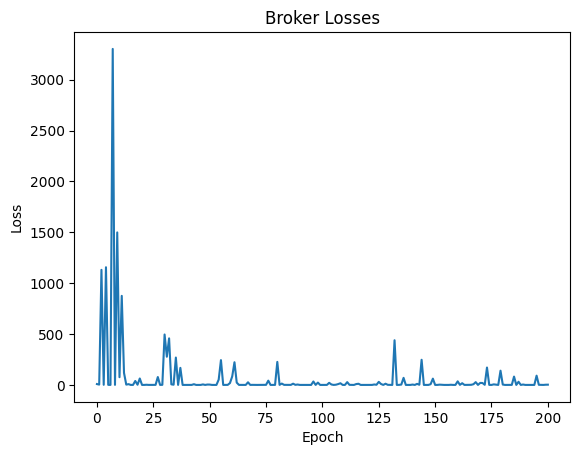

In [47]:
# Graph the broker losses
plt.plot(Broker.losses)
plt.title("Broker Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# Graph the Predictions

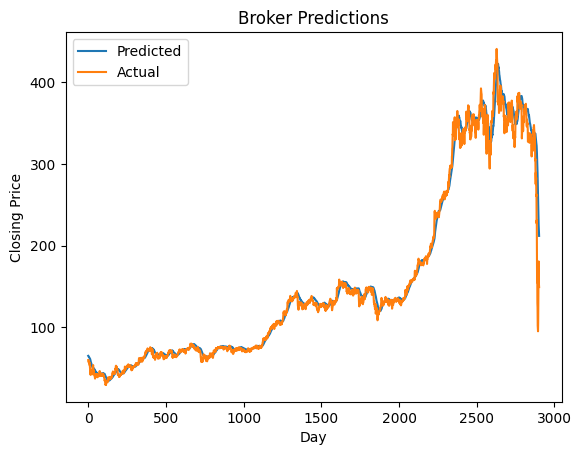

In [48]:
# Graph the broker predictions
plt.plot([x[0] for x in Broker.predictions], label="Predicted")
plt.plot([x[1] for x in Broker.predictions], label="Actual")
plt.title("Broker Predictions")
plt.xlabel("Day")
plt.ylabel("Closing Price")
plt.legend()
plt.show()